# Assembly Tree Generation and Evaluation

## Formulation
 - State Space S = {Every Possible Subassembly}
 - Action Space A = {Every Connection that can currently be removed}
 - P(s'|s,a) = Feasability Checks
 - R(s,a) = Cost of removing a certain connection in line with the dynamics 
 - Graph Assumption: Order doesn't matter

## Notes
 - Next Steps:
     - Randomly generate pathing as baseline
     - Compare to DQN approach


In [2]:
import sys, random, math, time, json
import numpy as np
import pprint as pp
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from itertools import count

%matplotlib inline

## Preliminary Code (Object Classes)

# HELPER FUNCTIONS

In [3]:
# Temporary Instantiations
Rewards = {}
seqConstraint = {}


def hierarchy_pos(G, root=None, width=20., vert_gap = 0.4, vert_loc = 0, xcenter = 0.5):  
    # From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):   
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos          
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


# Generating Subassemblies in a recursive manner
def recurGen(p, H, G):
    currCon = list(H.edges())
    if(len(currCon) > 0):
        i = G.number_of_nodes() + 1
        for c in currCon:
            Hnew = H.copy()
            Hnew.remove_edges_from([c])
            if(c in seqConstraint.keys() and seqConstraint[c] in Hnew.edges()):
                pass # This means a feasability constraint has been failed!
            else:
                idString = str(Hnew.edges())
                nextState = next((x for x, y in nx.get_node_attributes(G,'idS').items() if y == idString), None)
                if(nextState is not None):
                    Rew, Hnew = R(p, c, H)
                    G.add_edge(p, nextState, a=c, r=Rew)
                else:
                    G.add_node(i, idS=idString)
                    Rew, Hnew = R(p,c,H)
                    G.add_edge(p, i, a=c, r=Rew)
                    G = recurGen(i, Hnew, G)
            i = G.number_of_nodes() + 1
        return G
    else:
        return G


# Getting next set of possible states and actions
def nextGen(H):
    currCon = list(H.edges())
    G = nx.DiGraph()
    G.add_node(1, value=H, idS=str(H.edges()))

    if(len(currCon) > 0):
        for c in currCon:
            i = G.number_of_nodes() + 1
            if(c in seqConstraint.keys() and seqConstraint[c] in Hnew.edges()):
                pass # This means a feasability constraint has been failed!
            else:
                Hnew = H.copy()
                Hnew.remove_edges_from([c])
                G.add_node(i, idS=str(Hnew.edges()))
                Rew, Hnew = R(1,c,H)
                G.add_edge(1, i, a=c, r=Rew)

                # Hnew.remove_edges_from([c])
                # G.add_node(i, idS=str(Hnew.edges()))
                # G.add_edge(1, i, a=c, r=R(1,c))
        return G
    else:
        return None
    
    
# Checking Feasability
def T(sN, s, a):
    # Sequential Constraints are already handled via the tree generation!
    pass


# Cost structure which allows for an intermediary construction zone 
# between the supply vehicle and construction area
def Rcaz(s,a,H): # Reward Function Assuming there is a CAZ
    Rewards[(s,a)] = 0
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                if(Hnew.nodes[i[0]]["loc"] == "CL"): # Going from CL to SV
                    Hnew.nodes[i[0]]["loc"] = "SV"
                    Rewards[(s,a)] += -(0.0468 + 0.0499) #SV-CL + CL-SV
                else: # Going from CAZ to SV
                    Hnew.nodes[i[0]]["loc"] = "SV"
                    Rewards[(s,a)] += -(0.0403 + 0.0420) #SV-CAZ + CAZ-SV

            elif(len(i) == 2): # Have to fix last bit problem
                for p in i:
                    if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
                        Hnew.nodes[p]["loc"] = "CAZ"
                Rewards[(s,a)] += -(0.0307 + 0.0415) #SV-CL + CL-CAZ2

            elif(len(i) == 3): # Have to fix last problem
                for p in i:
                    if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
                        Hnew.nodes[p]["loc"] = "CAZ"
                Rewards[(s,a)] += -(0.0307 + 0.0475) #SV-CL + CL-CAZ3
    return Rewards[(s,a)], Hnew


# Reward Function Assuming there is NO CAZ (i.e, structures are constructed at the Supply Vehicle)
def RNOcaz(s,a,H): 
    Rewards[(s,a)] = 0
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                Rewards[(s,a)] += -(0.0468 + 0.0499) #SV-CL + CL-SV

            elif(len(i) == 2):
                Rewards[(s,a)] += -(0.0749 + 0.0499) #SV-CL + CL-SV2

            elif(len(i) == 3):
                Rewards[(s,a)] += -(0.0869 + 0.0499) #SV-CL + CL-SV3
    return Rewards[(s,a)], Hnew



def Rcustom(s,a,H):
    s = str(s)
    Rewards[(s,a)] = -0.1
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                Rewards[(s,a)] += -1 #SV-CL + CL-SV

            elif(len(i) == 2):
                Rewards[(s,a)] += -1.5 #SV-CL + CL-SV2

            elif(len(i) == 3):
                Rewards[(s,a)] += -1.75 #SV-CL + CL-SV3
    return Rewards[(s,a)], Hnew


def Rsimple(s,a,H):
    lab = str(s)
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    edges = fullE
    if(edges.index(a) <= sum(s)):
        Rewards[(lab,a)] = 1
    else:
        Rewards[(lab,a)] = 0
    return Rewards[(lab,a)], Hnew



# Allows you to pick which reward function to use!
def R(s, a, H):
    lab = str(s)
    if((lab,a) not in Rewards.keys()):
        Rewards[(lab,a)], Hnew = Rsimple(s,a,H)
    else:
        Hnew = H.copy()
        Hnew.remove_edges_from([a])
    return Rewards[(lab,a)], Hnew

## Additional Plots

In [ ]:
# State Growth Comparison


## Scenario Initialization

##### "Hubble"

CONFIGURATION: 
	20 Parts,
	19 Connections in Assembly,
	4980737 Potential Subassemblies, 
	9437185 Potential Edges, 
	0 Sequential Constraints


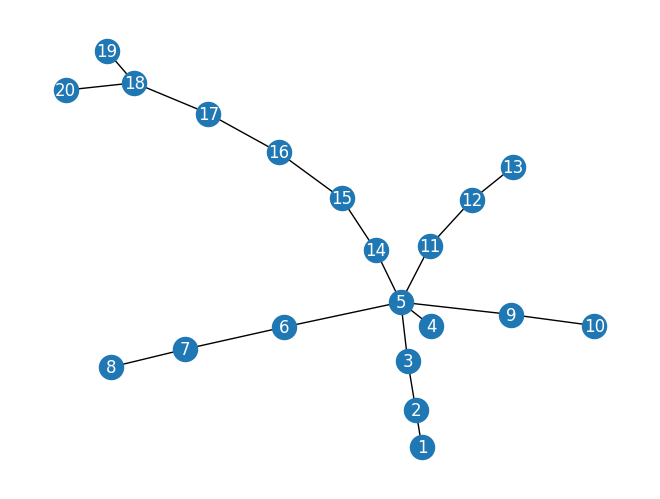

In [79]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "Hubble"

#define topology 
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(3,5)
H.add_edge(4,5)
H.add_edge(5,6)
H.add_edge(6,7)
H.add_edge(7,8)
H.add_edge(5,9)
H.add_edge(9,10)
H.add_edge(5,11)
H.add_edge(11,12)
H.add_edge(12,13)
H.add_edge(5,14)
H.add_edge(14,15)
H.add_edge(15,16)
H.add_edge(16,17)
H.add_edge(17,18)
H.add_edge(18,19)
H.add_edge(18,20)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Potential Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "Lattice"

CONFIGURATION: 
	9 Parts,
	12 Connections in Assembly,
	24577 Subassemblies, 
	45057 Potential Edges, 
	4 Sequential Constraints


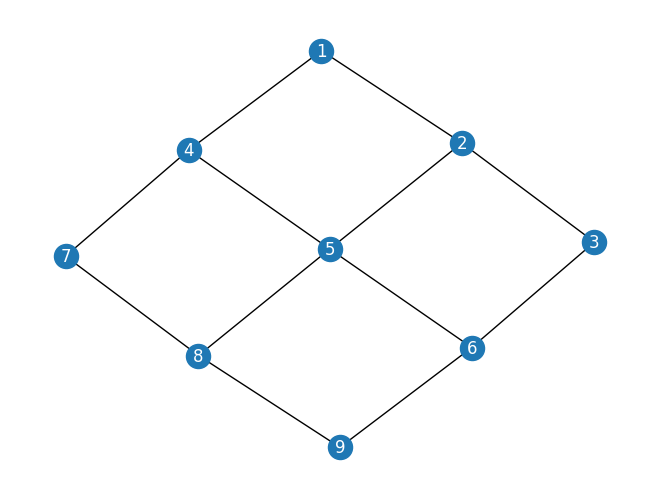

In [83]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "Lattice"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(1,4)
H.add_edge(5,4)
H.add_edge(5,2)
H.add_edge(6,5)
H.add_edge(6,3)
H.add_edge(7,4)
H.add_edge(8,7)
H.add_edge(8,5)
H.add_edge(9,8)
H.add_edge(9,6)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {(2,5): (1,4),
                 (2,5): (3,6),
                 (4,5): (1,2),
                 (4,5): (7,8),
                 (5,8): (4,7),
                 (5,8): (6,9),
                 (5,6): (2,3),
                 (5,6): (8,9)}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "2 x 3"

CONFIGURATION: 
	6 Parts,
	7 Connections in Assembly,
	449 Subassemblies, 
	769 Potential Edges, 
	4 Sequential Constraints


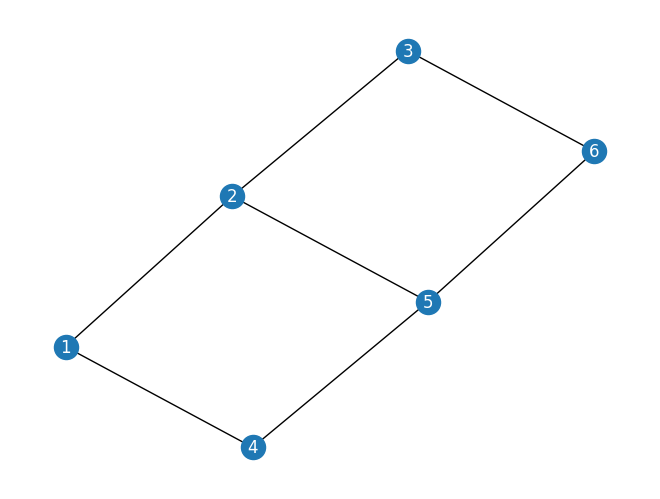

In [86]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "2x3"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(1,4)
H.add_edge(4,5)
H.add_edge(5,6)
H.add_edge(2,5)
H.add_edge(3,6)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {(2,5): (1,4),
                 (2,5): (3,6),
                 (4,5): (1,2),
                 (4,5): (7,8),
                 (5,8): (4,7),
                 (5,8): (6,9),
                 (5,6): (2,3),
                 (5,6): (8,9)}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "3-Piece"

CONFIGURATION: 
	3 Parts,
	3 Connections in Assembly,
	13 Subassemblies, 
	17 Potential Edges, 
	0 Sequential Constraints


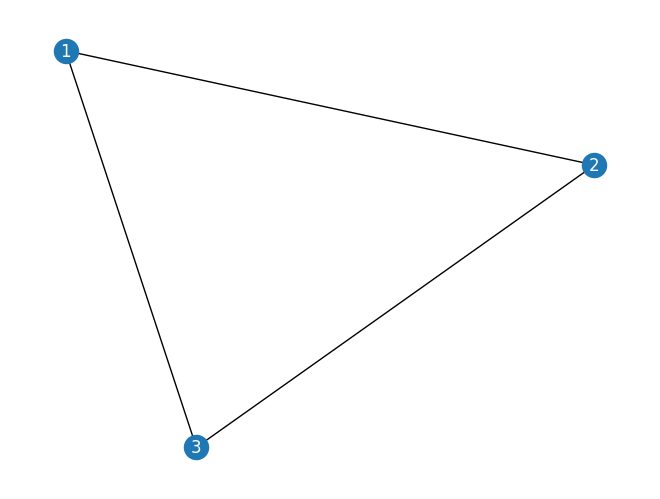

In [89]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "3Piece"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(3,1)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "4-Piece"

CONFIGURATION: 
	4 Parts,
	4 Connections in Assembly,
	33 Subassemblies, 
	49 Potential Edges, 
	0 Sequential Constraints


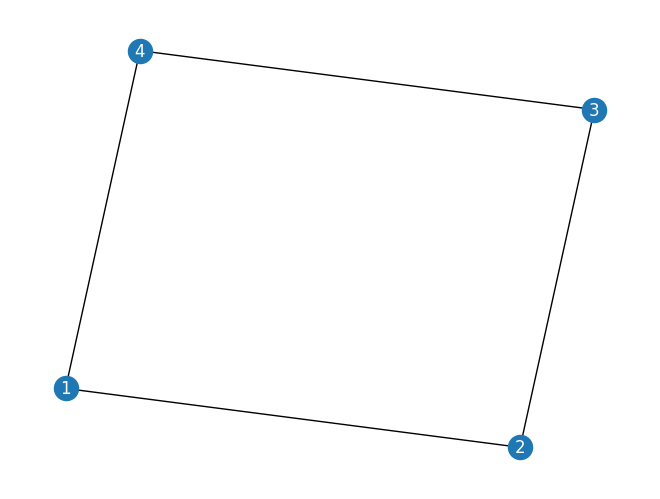

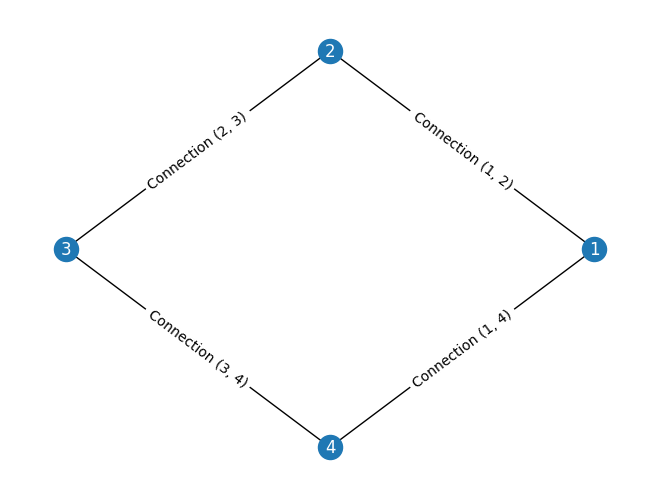

In [90]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "4Piece"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(3,4)
H.add_edge(4,1)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

fig = plt.figure()
pos = nx.circular_layout(H)
nx.draw(H, pos, with_labels=True, font_color="#FFFFFF")
labels = {i:"Connection "+str(i) for i in H.edges()}
nx.draw_networkx_edge_labels(H, pos, edge_labels=labels)
plt.savefig("RESULTS/FullyAssembled.eps", format="eps", dpi=1200)

##### "N Long Chain"

CONFIGURATION: 
	50 Parts,
	49 Connections in Assembly,
	13792273858822145 Subassemblies, 
	27021597764222977 Potential Edges, 
	0 Sequential Constraints


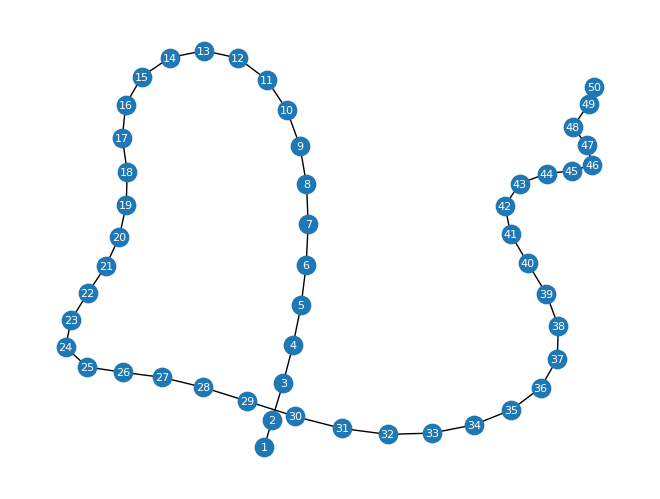

In [103]:
# Initialize the inputs (will later read in from file [JSON])
N = 50 # Number of Parts

Scenario = str(N)+"LongChain"

#define topology
H = nx.Graph()
for i in range(1,N):
    H.add_edge(i,i+1)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF", node_size=175, font_size=8)
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "Random Tree"

CONFIGURATION: 
	100 Parts,
	99 Connections in Assembly,
	31374352355648677687043404333057 Subassemblies, 
	62114879411183240673338457063425 Potential Edges, 
	0 Sequential Constraints


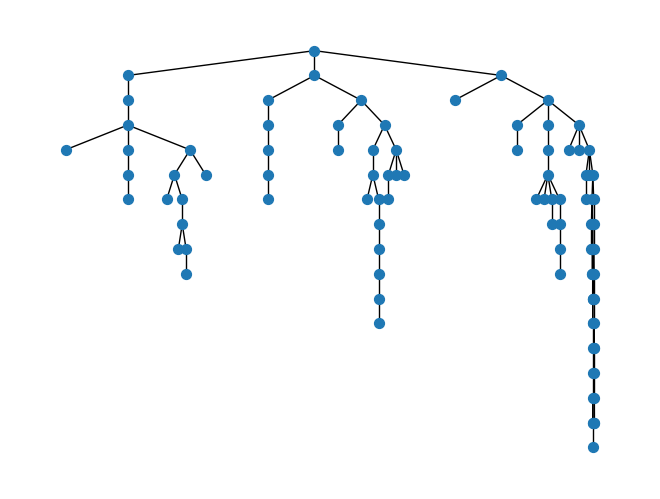

In [109]:
# Initialize the inputs (will later read in from file [JSON])
N = 100 # Number of Parts

Scenario = str(N)+"RandomTree"

#define topology
H = nx.random_tree(n=N)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

pos = hierarchy_pos(H,1)
nx.draw(H, pos, with_labels=False, node_size=50)
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

## Running the Assembly Generation

In [68]:
# Simple initial initialization (will later read in from file [JSON])
Rewards = {}
fullE = list(H.edges())

# Generate the assembly tree
start = time.time()
G = nx.DiGraph()
G.add_node(1, idS=str(H.edges()))
G = recurGen(1, H, G)
end = time.time()
print("Assembly Generation Time: %f" % (end-start))

print(list(H.edges()))
print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

TypeError: 'int' object is not iterable

# Graphing Suite

In [17]:
try:
    pos = hierarchy_pos(G,1)
except:
    pos = nx.planar_layout(G)
actions = nx.get_edge_attributes(G,'r')
labels = nx.get_node_attributes(G,'r')
nx.draw(G, pos, with_labels=True, font_color="#FFFFFF")
nx.draw_networkx_edge_labels(G, pos, edge_labels = actions)


try:
    S = range(1, G.number_of_nodes()+1)
    path = [1, π[1][0]]
    path_edges = [(1, path[-1])]
    while(True):
        currState = path[-1]
        nextState = π[currState][0]
        if(nextState in S):
            path.append(nextState)
            path_edges.append((currState, nextState))
        else:
            break
    print(path_edges)
    nx.draw_networkx_nodes(G,pos,nodelist=path,node_color='r')
    nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='r',width=1)
except:
    print("No Policy Found")

print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

No Policy Found
DONE: 1 Nodes and 0 Edges


In [ ]:
nx.draw(H, with_labels=True, font_color="#FFFFFF")

In [ ]:
V = G.copy()
try:
    plotVis(V)
except:
    try:
        plotVis(V)
    except:
        print("Nope!")